# Object detection

This first notebook extracts people from images using an accelerated Quantized Neural Network.

The second notebook processes those images to feed them to the third notebook.

The third notebook identifies the faces extrated from the people of the first notebook using an accelerated Binarized Neural Network.

# Detection (using YoloV2) 

Declare constants.

In [1]:
# Storage configuration
DATA_PATH = "data"
IMG_PATH = f"{DATA_PATH}/img"
SAMPLE_IMAGE_PATH = f"{IMG_PATH}/friends.jpg"
PICKLE_PATH = f"{DATA_PATH}/pickle"
PICKLE_FILE = f"{PICKLE_PATH}/detections.pkl"

# Python module configuration
DARKNET_PATH = "/opt/darknet"
PYTHON_PATH = "/usr/local/lib/python3.6"
PYTHON_PKG_PATH = f"{PYTHON_PATH}/dist-packages"
QNN_PATH = f"{PYTHON_PKG_PATH}/qnn"

# Classifier configurations
QNN_SIZE = 416  # width and height of images used by YoloV2
QNN_THRESHOLD = 0.3  # certainty that there is an object in a box
                     # lower -> more results
QNN_THRESHOLD_HIER = 0.5  # threshold to consider a class in a box
                          # 0: follow the most certain path until a leaf node

Import QNN, Darknet and other required modules.
A [custom version of darknet](https://github.com/giuliogamba/darknet) is installed in `/opt/darknet` when running the `setup.py` of QNN.

This notebook uses a [fork I made](https://github.com/mikelsr/darknet) of a current version of darknet with the required changes made for the QNN version.

In [2]:
import qnn
from qnn import TinierYolo, utils

import array
import ctypes
import cv2
import numpy as np
import os
import pickle
from PIL import Image, ImageOps
import sys
from time import time

sys.path.append(f"{DARKNET_PATH}/python")
import darknet

Load sample image of another student enjoying life.

In [3]:
sample_image = Image.open(SAMPLE_IMAGE_PATH)
sample_image

Create folder to store benchmarks and output files.

In [4]:
try:
    os.makedirs(PICKLE_PATH)
except FileExistsError:
    pass

## Load the QNN classifier

The QNN classifier will be used to identify people in an image.

In [5]:
classifier = TinierYolo()
classifier.init_accelerator()
net = classifier.load_network(json_layer=f"{QNN_PATH}/params/tinier-yolo-layers.json")

conv0_weights = np.load(f"{QNN_PATH}/params/tinier-yolo-conv0-W.npy",
                        encoding="latin1", allow_pickle=True)
conv0_weights_correct = np.transpose(conv0_weights, axes=(3, 2, 1, 0))
conv8_weights = np.load(f"{QNN_PATH}/params/tinier-yolo-conv8-W.npy",
                        encoding="latin1", allow_pickle=True)
conv8_weights_correct = np.transpose(conv8_weights, axes=(3, 2, 1, 0))
conv0_bias = np.load(f"{QNN_PATH}/params/tinier-yolo-conv0-bias.npy",
                     encoding="latin1", allow_pickle=True)
conv0_bias_broadcast = np.broadcast_to(conv0_bias[:, np.newaxis],
                                       (net["conv1"]["input"][0],
                                        net["conv1"]["input"][1] * net["conv1"]["input"][1]))
conv8_bias = np.load(f"{QNN_PATH}/params/tinier-yolo-conv8-bias.npy",
                     encoding="latin1", allow_pickle=True)
conv8_bias_broadcast = np.broadcast_to(conv8_bias[:, np.newaxis], (125, 13*13))
file_name_cfg = ctypes.c_char_p(f"{QNN_PATH}/params/tinier-yolo-bwn-3bit-relu-nomaxpool.cfg".encode())

net_darknet = darknet.lib.parse_network_cfg(file_name_cfg)

/usr/local/lib/python3.6/dist-packages/pynq/pl_server/device.py:641: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


## Identify objects in the sample image

**Note**: The first and last neural networks can't be HW accelerated.

Prepare sample image.

In [6]:
img_raw = darknet.load_image(ctypes.c_char_p(SAMPLE_IMAGE_PATH.encode()), 0, 0)
img_letterbox = darknet.letterbox_image(img_raw, QNN_SIZE, QNN_SIZE)
img = np.copy(np.ctypeslib.as_array(img_letterbox.data, (3, QNN_SIZE, QNN_SIZE)))
img = np.swapaxes(img, 0, 2)

# Store original dimensions of the image
W, H = img_raw.w, img_raw.h

### Run the first convolution layer

In [7]:
start = time()

img = img[np.newaxis, :, :, :]
conv0_ouput = utils.conv_layer(img, conv0_weights_correct,
                               b=conv0_bias_broadcast,
                               stride=2, padding=1)
conv0_output_quant = conv0_ouput.clip(0.0, 4.0)
conv0_output_quant = utils.quantize(conv0_output_quant/4, 3)

end = time()
micros = int((end - start) * 1e6)
print(f"First SW layer took {micros} microseconds.")

First SW layer took 233280ms.


### Run the core (middle) layers

The core layers are quantized and HW accelerated.

In [ ]:
out_ch = net['conv7']['output'][0]
out_dim = net['conv7']['output'][1]

conv_output = classifier.get_accel_buffer(out_ch, out_dim)
conv_input = classifier.prepare_buffer(conv0_output_quant*7);

# Run actual layers
start = time()
classifier.inference(conv_input, conv_output)
end = time()

conv7_out = classifier.postprocess_buffer(conv_output)


micros = int((end - start) * 1e6)
print(f"HW layers took {micros} microseconds.")

### Run the final layer

Not quantized, not HW accelerated.

In [9]:
start = time()

conv7_out_reshaped = conv7_out.reshape(out_dim, out_dim, out_ch)
conv7_out_swapped = np.swapaxes(conv7_out_reshaped, 0, 1) # exp 1
conv7_out_swapped = conv7_out_swapped[np.newaxis, :, :, :] 

conv8_output = utils.conv_layer(conv7_out_swapped, conv8_weights_correct,
                                b=conv8_bias_broadcast,stride=1)  
conv8_out = conv8_output.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

end = time()
micros = int((end - start) * 1e6)
print(f"Last SW layer took {micros} microseconds.")

Last SW layer took 60974ms.


### Extract boxes

Extract boxes from the result with: the object class, probability and box coordinates.

Create a variable to store the number of boxes found. This should only be run **once** and reuse the pointer every loop.

In [10]:
num = ctypes.c_int(0)
num_pointer = ctypes.pointer(num)

Add results of the last layer to the net structure to extract the boxes using the darknet library.

In [11]:
darknet.lib.forward_region_layer_pointer_nolayer(net_darknet, conv8_out)

690421440

Call the funcion to retrieve the boxes of the last layer of the network.

In [12]:
num = ctypes.c_int(0)
num_pointer = ctypes.pointer(num)

detections = darknet.get_network_boxes(net_darknet, QNN_SIZE, QNN_SIZE,
                                       QNN_THRESHOLD, QNN_THRESHOLD_HIER,
                                       None, 0, num_pointer)
n = num_pointer[0]

# YoloV2 will give 13x13x5=845 boxes
assert n == 13*13*5

Load the class names from the `voc.data` file. This should only be run **once** per program.

In [13]:
meta = darknet.load_meta(ctypes.c_char_p(f"{DARKNET_PATH}/cfg/voc.data".encode()))
assert meta.classes == 20

Sort the boxes according to probabilities.

In [14]:
darknet.do_nms_sort(detections, n, meta.classes, QNN_THRESHOLD)

20

Extract information from the boxes to use next.

In [15]:
def get_box_coords(box):
    """
    center of the box: (box.x, box.y)
    dimensions of the box: (box.w, box.y)
    """

    left = int((box.x - box.w/2.))
    top = int((box.y -box.h/2.))
    
    right = int((box.x + box.w/2.))
    bottom = int((box.y + box.h/2.))
    
    
    if left < 0:
        left = 0
    if right >= W:
        right = W - 1
    if top < 0:
        top = 0
    if bottom >= H:
        bottom = H - 1
    
    # print(f"x: {box.x}, y: {box.y}, w: {box.w}, h: {box.h}")

    return left, top, right, bottom

results = []
for i in range(n):
    for j in range(meta.classes):
        if detections[i].prob[j] > 0.0 and meta.names[j] == b"person":
            results.append((
                    meta.names[j],
                    detections[i].prob[j],
                    (get_box_coords(detections[i].bbox))
                ))

In [16]:
from pprint import pprint
pprint(results)

[(b'person', 0.7872711420059204, (156, 109, 336, 411))]


Display results

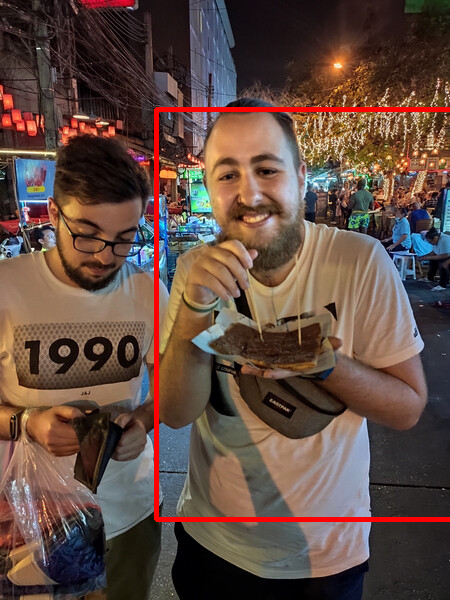

In [17]:
out = sample_image.convert("RGB")
cv_img = cv2.cvtColor(np.array(out)[:, :, ::-1], cv2.COLOR_RGB2BGR)

for result in results:
    x, y, w, h = result[2]
    cv2.rectangle(img=cv_img, rec=(x, y, w, h), color=255, thickness=3)

Image.fromarray(cv_img)

Free the detections now that the information has been extracted.

In [18]:
darknet.free_detections(detections, n)

0

# Save results

Store results in a pickle file so they can later be used from other notebooks.

![I turned the data into a pickle!](data/img/pickle.jpg)

In [19]:
data = {
    "image": np.array(sample_image),
    "coords": [result[2] for result in results],
    "method": "yolov2"
}

with open(PICKLE_FILE, "wb") as f:
    pickle.dump(data, f)

# Cleanup

Before switching to another notebook the cleanup code must be run.

In [20]:
classifier.deinit_accelerator()

In [21]:
from pynq import Xlnk

xlnk = Xlnk()
xlnk.xlnk_reset()

Next: `2. Face extraction`